# Прогнозирование оттока клиентов телекоммуникационной компании

Предоставлен набор данных от оператора связи «Ниединогоразрыва.ком». Задача: прогнозирование оттока клиентов, иными словами задача бинарной классификации. Необходимо построить модель, которая будет способна выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

<b>Описание услуг</b>

Оператор предоставляет два основных типа услуг: 
* Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
* Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

<b>Также доступны такие услуги:</b>
* Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
* Выделенная линия технической поддержки (TechSupport);
* Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
* Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

<b>Описание данных<b/>

Данные состоят из файлов, полученных из разных источников:
* contract_new.csv — информация о договоре;
* personal_new.csv — персональные данные клиента;
* internet_new.csv — информация об интернет-услугах;
* phone_new.csv — информация об услугах телефонии.

Во всех файлах столбец customerID содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.
    
<b>Цель проекта: </b> ROC-AUC не менее 0.85

## План работы

* <b>Загрузка данных</b><br>
Загрузка данных и поверхностный анализ: проверка на наличие пропусков, дубликатов, анализ типов данных. 
* <b>Разведочный анализ данных</b><br>
    - Объединение таблиц в единый датафрейм, удаление невалидных признаков, изменение типов данных в соответствии со смыслов признака. 
    - Заполнение/удаление пропусков, возникщими в результате объединения данных.
    - Анализ корреляции признаков. 
    - Когортнный анализ признаков и составление потрета лояльного и нелояльного потребителя. 
* <b>Подготовка данных</b><br>
    - Разбиение данных на обучающую и текстовую выборки.
    - Масштабирование числовых признаков и кодирование категориальных. 
* <b>Обучение моделей</b><br>
    - Обучение выбранных моделей и подбор гиперпараметров. 
    - Анализ результатов и выбор лучшей модели для использования ее на тестовых данных.
    - Анализ важности признаков.
* <b>Тестирование</b><br>
    - Анализ результатов лучшей модели на тесторвой выборке. 
* <b>Подготовка отчета</b><br>
    - Написание отчета о проделанной работе, интерпретация результатов 


## Ознакомление с данными

In [2]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import phik
import plotly.express as px
from catboost import Pool

from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score

warnings.filterwarnings('ignore')

In [3]:
try: 
    contacts = pd.read_csv('/datasets/contract_new.csv')
    personal = pd.read_csv('/datasets/personal_new.csv.csv')
    internet = pd.read_csv('/datasets/internet_new.csv')
    phone = pd.read_csv('/datasets/phone_new.csv')
except:
    contacts = pd.read_csv('https://code.s3.yandex.net/datasets/contract_new.csv')
    personal = pd.read_csv('https://code.s3.yandex.net/datasets/personal_new.csv')
    internet = pd.read_csv('https://code.s3.yandex.net/datasets/internet_new.csv')
    phone = pd.read_csv('https://code.s3.yandex.net/datasets/phone_new.csv')

In [5]:
# Функция для автоматизации ознакомления с данными
def brief_df (df):
    # Подсчитываем пустые значения и уникальные значение
    rows_na =df.isna().sum().reset_index().rename(columns={0: "valuesNa"})
    rows_notna = df.notna().sum().reset_index().rename(columns={0: "valuesNotNa"})
    rows_analysis = pd.merge(rows_na, rows_notna, on="index", how= "outer")
    rows_analysis["completeRatio"] = round((rows_analysis["valuesNotNa"]) / (rows_analysis["valuesNotNa"]+rows_analysis["valuesNa"])*100,2)

    cardinality = df.nunique().reset_index().rename(columns={0: "cardinality"})
    rows_analysis = pd.merge(rows_analysis, cardinality)

    # Размер датасета и кол-во дубликатов
    print("Размер:", df.shape)
    dup_raw = df.duplicated ().sum()
    dup_per = round((dup_raw*100)/df.shape[0],2)
    print (f"Дубликаты: {dup_raw}: {dup_per}%")

    # Статистика по пустым значениям
    print("Проверка на отсутсвующие значениия")
    display(rows_analysis)
    print()

    # Первые пять строк
    print("Первые пять строк")
    display(df.head())
    print()

    print("Тип данных")
    display(df.dtypes)
    print()

    print("Анализ числовых признаков")
    display(df.describe(datetime_is_numeric=True))
    print()

    print("Анализ нечисловых признаков")
    display(df.select_dtypes(include=["object"]).describe())    
    print()

In [6]:
data_list = [contacts, personal, internet, phone]

In [7]:
brief_df(contacts)

Размер: (7043, 8)
Дубликаты: 0: 0.0%
Проверка на отсутсвующие значениия


,index,valuesNa,valuesNotNa,completeRatio,cardinality
0,customerID,0,7043,100.0,7043
1,BeginDate,0,7043,100.0,77
2,EndDate,0,7043,100.0,67
3,Type,0,7043,100.0,3
4,PaperlessBilling,0,7043,100.0,2
5,PaymentMethod,0,7043,100.0,4
6,MonthlyCharges,0,7043,100.0,1585
7,TotalCharges,0,7043,100.0,6658



Первые пять строк


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5



Тип данных


customerID           object
BeginDate            object
EndDate              object
Type                 object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
dtype: object


Анализ числовых признаков


,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000



Анализ нечисловых признаков


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,TotalCharges
count,7043,7043,7043,7043,7043,7043,7043
unique,7043,77,67,3,2,4,6658
top,7590-VHVEG,2014-02-01,No,Month-to-month,Yes,Electronic check,
freq,1,366,5942,3875,4171,2365,11


In [8]:
brief_df(personal)

Размер: (7043, 5)
Дубликаты: 0: 0.0%
Проверка на отсутсвующие значениия


,index,valuesNa,valuesNotNa,completeRatio,cardinality
0,customerID,0,7043,100.0,7043
1,gender,0,7043,100.0,2
2,SeniorCitizen,0,7043,100.0,2
3,Partner,0,7043,100.0,2
4,Dependents,0,7043,100.0,2



Первые пять строк


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No



Тип данных


customerID       object
gender           object
SeniorCitizen     int64
Partner          object
Dependents       object
dtype: object


Анализ числовых признаков


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000



Анализ нечисловых признаков


,customerID,gender,Partner,Dependents
count,7043,7043,7043,7043
unique,7043,2,2,2
top,7590-VHVEG,Male,No,No
freq,1,3555,3641,4933


In [9]:
brief_df(internet)

Размер: (5517, 8)
Дубликаты: 0: 0.0%
Проверка на отсутсвующие значениия


,index,valuesNa,valuesNotNa,completeRatio,cardinality
0,customerID,0,5517,100.0,5517
1,InternetService,0,5517,100.0,2
2,OnlineSecurity,0,5517,100.0,2
3,OnlineBackup,0,5517,100.0,2
4,DeviceProtection,0,5517,100.0,2
5,TechSupport,0,5517,100.0,2
6,StreamingTV,0,5517,100.0,2
7,StreamingMovies,0,5517,100.0,2



Первые пять строк


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No



Тип данных


customerID          object
InternetService     object
OnlineSecurity      object
OnlineBackup        object
DeviceProtection    object
TechSupport         object
StreamingTV         object
StreamingMovies     object
dtype: object


Анализ числовых признаков


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785



Анализ нечисловых признаков


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


In [10]:
brief_df(phone)

Размер: (6361, 2)
Дубликаты: 0: 0.0%
Проверка на отсутсвующие значениия


,index,valuesNa,valuesNotNa,completeRatio,cardinality
0,customerID,0,6361,100.0,6361
1,MultipleLines,0,6361,100.0,2



Первые пять строк


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes



Тип данных


customerID       object
MultipleLines    object
dtype: object


Анализ числовых признаков


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390



Анализ нечисловых признаков


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


### Промежуточный вывод

В сырых данных отсутствуют пропуски и явные дубликаты. Некоторые признаки имеют некорректный тип данных, например, TotalCharges и BeginDate. На следующих шагах необходимо привести признаки  к необходим типам, а также убрать невалидные признаки.  

Данные необходимо объединить в один датафрейм для дальнейшей подготовки их к обучению моделей. После объединения предположительно в данных появятся пропуски, поскольку количество строк в предоставленных таблицах отличается. Это связано с тем, кто не всех клиенты пользуются всем спектром услуг компании. 

Целевой признак - EndDate. 

## Подготовка данных

Объединим сырые данные в один датафрейм

In [11]:
df = contacts.merge(phone, how='outer', on='customerID').merge(internet, how='outer', on='customerID').merge(personal, how='outer', on='customerID')

In [12]:
df.shape

(7043, 20)

Для удобства приведем названия столбцов к змеиному регистру

In [15]:
new_columns = []
for name in df.columns:
    new_columns.append(re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name).lower())
df.columns = new_columns

In [16]:
df = df.set_index('customerid')

Создадим столбец для таргета. В него попадут данные из end_date. Значение "No" заменим на 0 - это будет означать, что пользователь по-прежнему является клиентом компании. Все остальные значение заменим на 1. Это будет означать, что клиент ушел. 

In [17]:
df['target'] = df['end_date']
df['target'] = df['target'].replace('No', 0)
df.loc[df['target'] != 0, 'target'] = 1
df['target'] = df['target'].astype('int8')
df['target'].unique()

array([0, 1], dtype=int8)

In [18]:
df['target'].mean()

0.15632542950447254

В целевом признаке присутствует дисбаланс классов. Так, на ушедших клиентов прихоится порядка 16% из всех наблюдений. Необходимо это учесть при разбиении на обучающую и тестовую выборки. 

Столбец multiple_lines содержит информации о возможности ведения параллельных линий во время звонка. Для целей настоящего исследования будем считать этот признак невалидным. В данном контексте, возможно, большую ценность имеет факт оказания пользователю услуг телефонии. На основе этого столбца создадим признак "phone": Nan заменим на 0, все остальные значения на 1.

In [19]:
df.groupby('multiple_lines', dropna=False).count()

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streamingtv,streaming_movies,gender,senior_citizen,partner,dependents,target
multiple_lines,,,,,,,,,,,,,,,,,,,
No,3390,3390,3390,3390,3390,3390,3390,2206,2206,2206,2206,2206,2206,2206,3390,3390,3390,3390,3390
Yes,2971,2971,2971,2971,2971,2971,2971,2629,2629,2629,2629,2629,2629,2629,2971,2971,2971,2971,2971
NaN,682,682,682,682,682,682,682,682,682,682,682,682,682,682,682,682,682,682,682


In [20]:
df['phone'] = df['multiple_lines']
df['phone'] = df['phone'].fillna(0)
df.loc[df['phone'] != 0, 'phone'] = 1
df['phone'] = df['phone'].astype('int8')
df['phone'].unique()

array([0, 1], dtype=int8)

Используя данные столбцов begin_date и end_date можно получить новый признак - сколько пользователь является клиентом компании. Это в том числе поможет понять, какие клиент более склонны к оттоку: новые или старые. Для это приведем данные в типу datetime, отсутствуеющие значения в end_date заменим на дату актуальности данных - 1 февраля 2020.

In [21]:
df['end_date'] = df['end_date'].replace('No', '2020-02-01')
df['end_date'] = pd.to_datetime(df['end_date'], format='%Y-%m-%d') 
df['begin_date'] = pd.to_datetime(df['begin_date'], format='%Y-%m-%d')
df['diff_days'] = (df['end_date'] - df['begin_date']) / np.timedelta64 ( 1 , 'D')

Пока сложно сказать, какое имеет значение тип оплаты услуг, но из этого признака можно выделить две группы: с автоматическеми платежами и без. Создпдим новый признак automatic_payment на основе payment_method.

In [22]:
df['automatic_payment'] = df['payment_method'].apply(lambda x: 1 if 'automatic' in x else 0).astype('int8')

По аналогии с услугами телефонии, возможно, не так важен тип интернет-подключения, как сам факт оказания интернет-услуг. Создадим новый признак internet на основе столбца internet_service.

In [23]:
df['internet'] = df['internet_service']
df['internet'] = df['internet'].fillna(0)
df.loc[df['internet'] != 0, 'internet'] = 1
df['internet'] = df['internet'].astype('int8')
df['internet'].unique()

array([1, 0], dtype=int8)

Заменим все yes/no на 1/0.

В данных образовались пропуски в результате слияния таблиц. NaN образовались в тех случаях, когда клинет пользовался не только интернет-услугами, либо телефонией. Заполним все пропуски значением No_service.

In [24]:
df = df.fillna('No_service')

Приведем столбцы к соответствующему типа данных, в том числе с учетом занимаемой памяти(для этого датасета это не критично, но и лишним не будет)

In [25]:
df[df['total_charges'] == ' '].head(5)

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,multiple_lines,internet_service,online_security,...,streaming_movies,gender,senior_citizen,partner,dependents,target,phone,diff_days,automatic_payment,internet
customerid,,,,,,,,,,,,,,,,,,,,,
4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,,No_service,DSL,Yes,...,No,Female,0,Yes,Yes,0,0,0.0,1,1
3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,,No,No_service,No_service,...,No_service,Male,0,No,Yes,0,1,0.0,0,0
5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,,No,DSL,Yes,...,Yes,Female,0,Yes,Yes,0,1,0.0,0,1
4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,,Yes,No_service,No_service,...,No_service,Male,0,Yes,Yes,0,1,0.0,0,0
1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,,No_service,DSL,Yes,...,No,Female,0,Yes,Yes,0,0,0.0,1,1


В столбце total_charges присутствуют пропуски. По всей видимо это связно с тем, что клиент еще не успел произвести ни одной оплаты. Так, begin_date соответствет дате выгрузки данных. Поскольку подобных наблюдений только 11 шт. удалим их из данных. 

In [26]:
df['total_charges'] = df['total_charges'].replace(' ', np.nan)
df = df.dropna()

In [27]:
df['total_charges'] = df['total_charges'].astype('float')

Из данных удалены пропуски, признаки приведены к нужным типам данным. Взглянем на итоговый датафрейм

In [28]:
brief_df(df)

Размер: (7032, 24)
Дубликаты: 4: 0.06%
Проверка на отсутсвующие значениия


,index,valuesNa,valuesNotNa,completeRatio,cardinality
0,begin_date,0,7032,100.0,76
1,end_date,0,7032,100.0,67
2,type,0,7032,100.0,3
3,paperless_billing,0,7032,100.0,2
4,payment_method,0,7032,100.0,4
5,monthly_charges,0,7032,100.0,1584
6,total_charges,0,7032,100.0,6657
7,multiple_lines,0,7032,100.0,3
8,internet_service,0,7032,100.0,3
9,online_security,0,7032,100.0,3



Первые пять строк


,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,multiple_lines,internet_service,online_security,...,streaming_movies,gender,senior_citizen,partner,dependents,target,phone,diff_days,automatic_payment,internet
customerid,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,No_service,DSL,No,...,No,Female,0,Yes,No,0,0,31.0,0,1
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,No,DSL,Yes,...,No,Male,0,No,No,0,1,1036.0,0,1
3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,No,DSL,Yes,...,No,Male,0,No,No,0,1,123.0,0,1
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,No_service,DSL,Yes,...,No,Male,0,No,No,0,0,1371.0,1,1
9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,No,Fiber optic,No,...,No,Female,0,No,No,0,1,153.0,0,1



Тип данных


begin_date           datetime64[ns]
end_date             datetime64[ns]
type                         object
paperless_billing            object
payment_method               object
monthly_charges             float64
total_charges               float64
multiple_lines               object
internet_service             object
online_security              object
online_backup                object
device_protection            object
tech_support                 object
streamingtv                  object
streaming_movies             object
gender                       object
senior_citizen                int64
partner                      object
dependents                   object
target                         int8
phone                          int8
diff_days                   float64
automatic_payment              int8
internet                       int8
dtype: object


Анализ числовых признаков


,begin_date,end_date,monthly_charges,total_charges,senior_citizen,target,phone,diff_days,automatic_payment,internet
count,7032,7032,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000
mean,2017-04-28 23:14:44.641638400,2019-10-15 22:19:02.662116096,64.798208,2118.621822,0.162400,0.156570,0.903299,899.961320,0.435580,0.783845
min,2013-10-01 00:00:00,2014-06-01 00:00:00,18.250000,19.050000,0.000000,0.000000,0.000000,28.000000,0.000000,0.000000
25%,2015-06-01 00:00:00,2020-02-01 00:00:00,35.587500,439.745000,0.000000,0.000000,1.000000,276.000000,0.000000,1.000000
50%,2017-09-01 00:00:00,2020-02-01 00:00:00,70.350000,1345.275000,0.000000,0.000000,1.000000,761.000000,0.000000,1.000000
75%,2019-04-01 00:00:00,2020-02-01 00:00:00,89.862500,3239.317500,0.000000,0.000000,1.000000,1461.000000,1.000000,1.000000
max,2020-01-01 00:00:00,2020-02-01 00:00:00,118.750000,9221.380000,1.000000,1.000000,1.000000,2314.000000,1.000000,1.000000
std,NaN,NaN,30.085974,2112.736199,0.368844,0.363421,0.295571,682.738777,0.495868,0.411650



Анализ нечисловых признаков


,type,paperless_billing,payment_method,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streamingtv,streaming_movies,gender,partner,dependents
count,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032
unique,3,2,4,3,3,3,3,3,3,3,3,2,2,2
top,Month-to-month,Yes,Electronic check,No,Fiber optic,No,No,No,No,No,No,Male,No,No
freq,3875,4168,2365,3385,3096,3497,3087,3094,3472,2809,2781,3549,3639,4933


Посмотрим на портрет лояльного и не ушедшего клиента и узнаем, какими услугами они чаще пользовались. 

In [92]:
data = df.replace('Yes', 1).replace('No', 0).replace('No_service', np.nan)

In [93]:
data = data.groupby('target').agg('mean').drop(['monthly_charges', 'total_charges', 'diff_days'], axis=1).T

In [94]:
data.rename(columns = {0:'Лояльный', 1:'Ушедший'}, inplace = True)

In [95]:
data

target,Лояльный,Ушедший
paperless_billing,0.581184,0.654859
multiple_lines,0.427531,0.679359
online_security,0.350033,0.441020
online_backup,0.408007,0.595112
device_protection,0.408663,0.584485
tech_support,0.359221,0.422954
streamingtv,0.463575,0.620616
streaming_movies,0.464887,0.643996
senior_citizen,0.153431,0.210718
partner,0.450851,0.653043


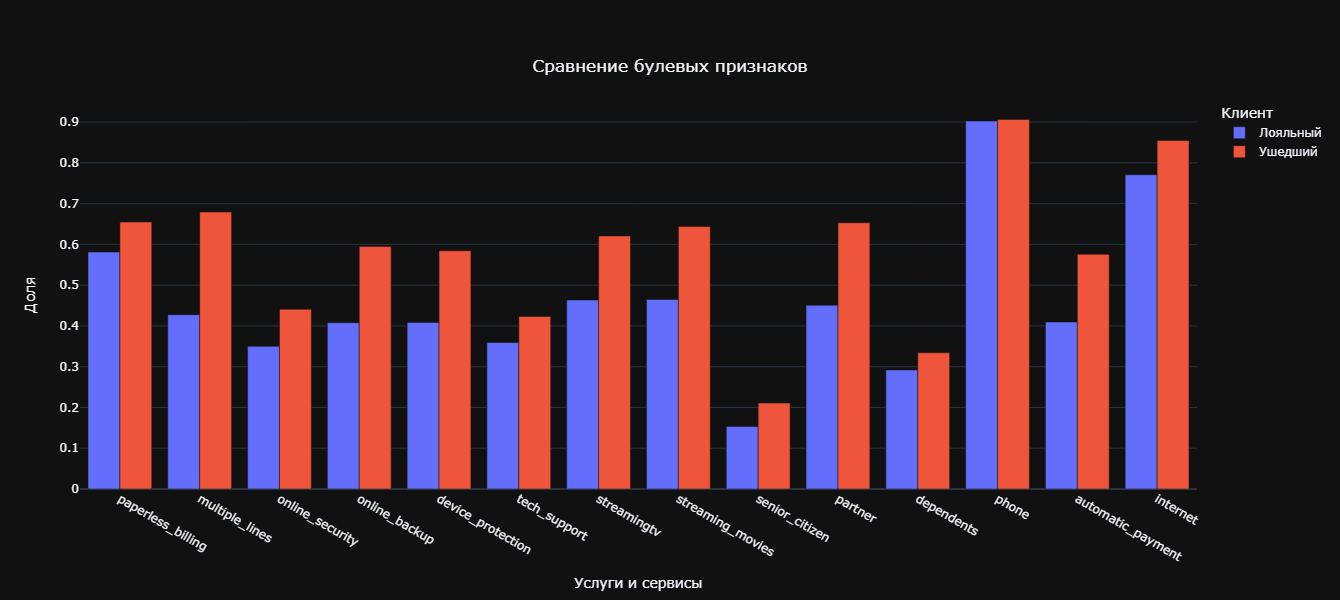

In [96]:
fig = px.bar(data,
             y = data.columns,
             x = data.index,
             title='Сравнение булевых признаков',
             template='plotly_dark',
             barmode='group',
             height=600, 
             labels={"target": "Клиент"})

fig.update_layout(yaxis_title='Доля', 
                  xaxis_title='Услуги и сервисы', 
                  title={'text': 'Сравнение булевых признаков',
                        'y':0.9,
                        'x':0.5},
                  showlegend=True)

fig.show()

Ушедшие клиенты нехначительно чаще пользовались услугами интернета и значительно чаще пользовались дополнительными интернет-услугами. Также ушедшие клиенты практически в равной степени пользовать услугами телефонии, но в то же время чаще дополнительными услугами. При этом чаще уходят состоящие в браке пенсионеры с подключенными автоматическими платежами. 

In [97]:
charges_median_mean = df.groupby('target')['monthly_charges', 'total_charges', 'diff_days'].agg(['median', 'mean'])

In [98]:
charges_median_mean

monthly_charges            total_charges              diff_days  \
                median       mean        median         mean    median   
target                                                                   
0                69.25  62.803043       1194.28  2071.701614     702.0   
1                84.20  75.546004       2139.03  2371.377275     915.0   

                   
             mean  
target             
0       895.33856  
1       924.86376

Средние значения monthly_charges, total_charges, diff_month выше у ушедших клиентов. Это можео интерпретировать следующим образом: более склонны к отттоку старые клиенты с более высокими тратами за услуги. 

Посмотрим на распределение месячных и общих трат.

In [132]:
data = df[['monthly_charges', 'total_charges', 'diff_days', 'target', 'begin_date']]

In [133]:
data['target'] = data['target'].replace(0, 'Лояльный').replace(1, 'Ушедший')

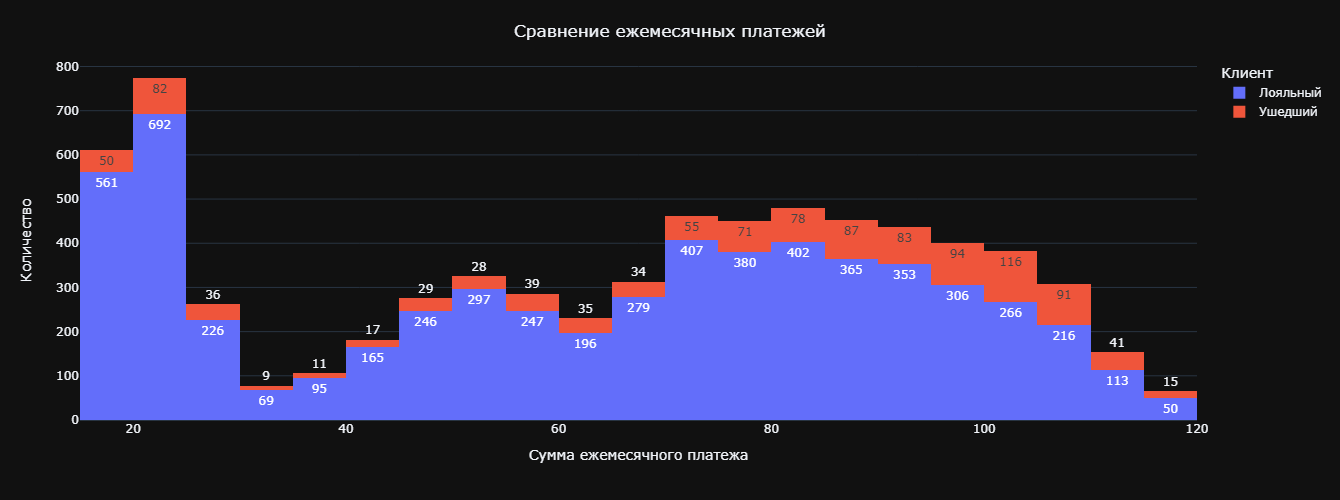

In [136]:
fig = px.histogram(data, 
                   x="monthly_charges", 
                   color="target", 
                   nbins=50, 
                   height=500,              
                   template='plotly_dark', 
                   labels={"target": "Клиент"},
                   text_auto=True)

fig.update_layout(yaxis_title='Количество', 
                  xaxis_title='Сумма ежемесячного платежа', 
                  title={'text': 'Сравнение ежемесячных платежей',
                        'y':0.95,
                        'x':0.5},
                  showlegend=True)
fig.show()

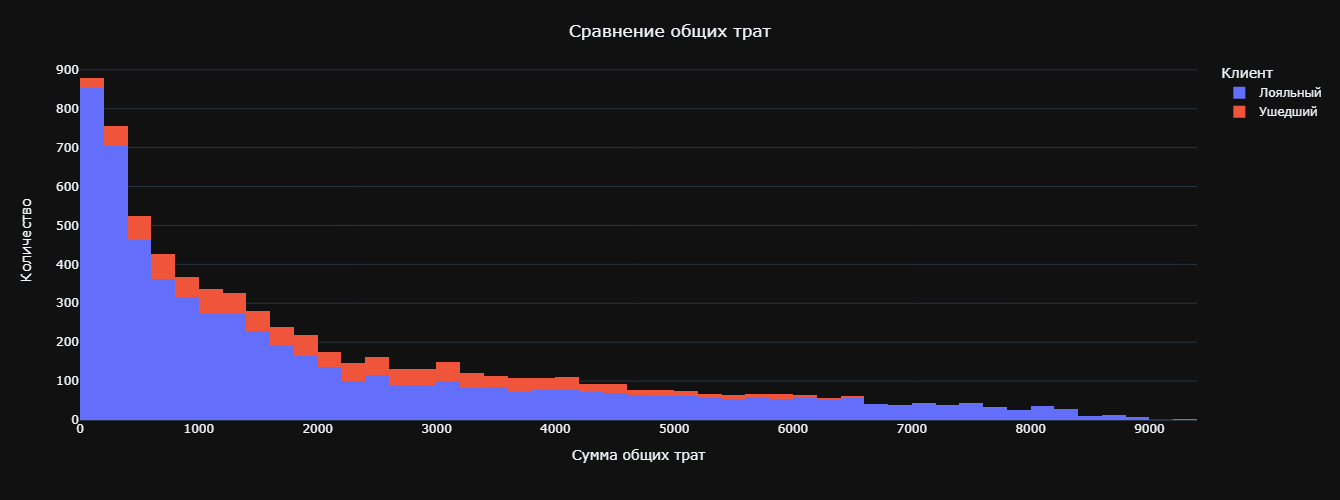

In [135]:
fig = px.histogram(data, 
                   x="total_charges", 
                   color="target", 
                   nbins=50, 
                   height=500,              
                   template='plotly_dark', 
                   labels={"target": "Клиент"})

fig.update_layout(yaxis_title='Количество', 
                  xaxis_title='Сумма общих трат', 
                  title={'text': 'Сравнение общих трат',
                        'y':0.95,
                        'x':0.5},
                  showlegend=True)
fig.show()

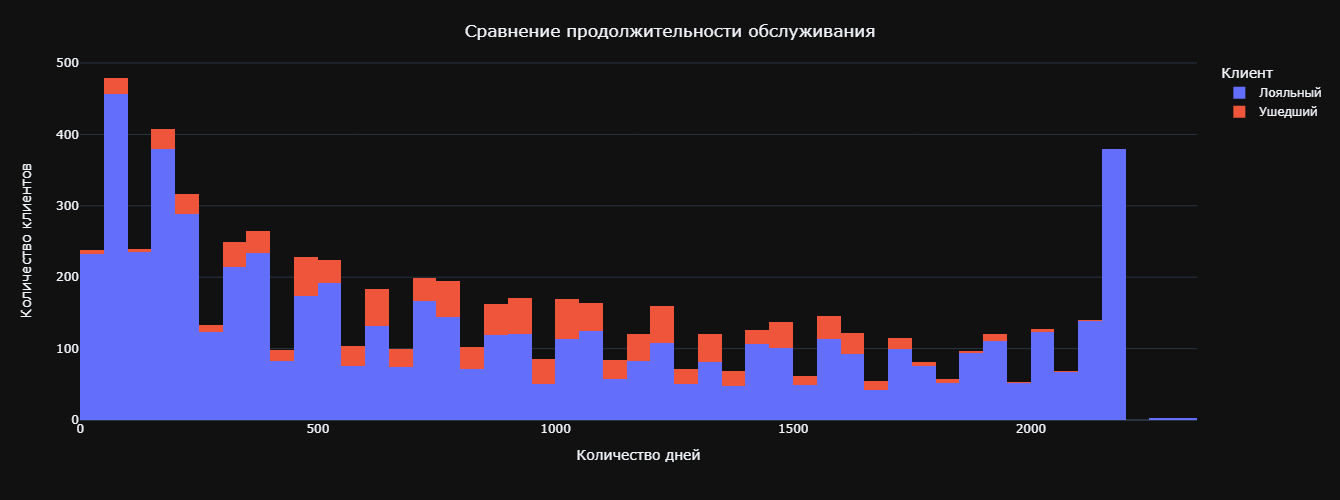

Чаще всего тратят примерно около 20 долларов в месяц. При этом в компании большое количество пользователей с низким значение общих трат, что может говорить о большом количестве новых клиентов. Чтобы убедиться в этом посмотрим на распределение срок, в течение которого пользователей является клиентом компании. 

Действительно, наиболее количество пользователей являются клиентами компании менее года. В дальнейшем их количество уменьшается в зависимости от увеличения срока. Однако число пользователей, которые пользуяются услугами компании более больше 5 лет начинает расти. 

## Анализ корреляции признаков

In [46]:
df = df.drop(['end_date',  'begin_date'], axis=1)

In [47]:
phik_overview = df.phik_matrix(interval_cols = ['diff_days', 'monthly_charges', 'total_charges'])

In [49]:
sns.set(rc={'figure.figsize':(12,10)})

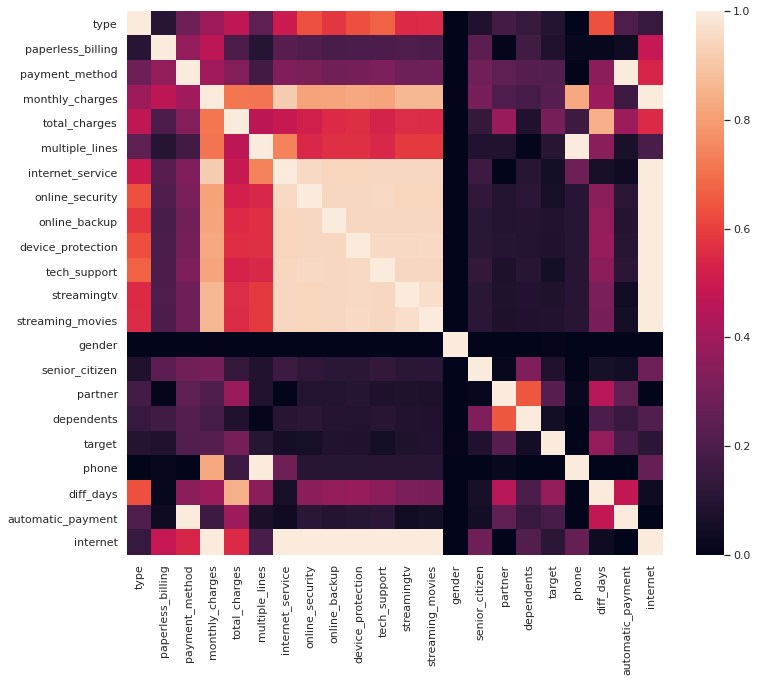

In [50]:
sns.heatmap(phik_overview);

В данных присутствует средняя корреляция между у monthly_charges и total_charges с интернет услугами и сервисами. В то же время бросается в глаза отсутствие какой-либо корреляции пола пользователя с другими признаками, в том числе и с целевым. 

In [51]:
phik_overview['target'].sort_values(ascending=False)

target               1.000000
diff_days            0.374101
total_charges        0.303758
partner              0.227597
monthly_charges      0.225823
payment_method       0.214300
automatic_payment    0.188780
internet             0.113949
multiple_lines       0.105172
type                 0.094622
online_backup        0.089771
streaming_movies     0.086371
senior_citizen       0.085708
device_protection    0.085665
paperless_billing    0.082789
streamingtv          0.078554
online_security      0.058630
internet_service     0.056279
tech_support         0.051442
dependents           0.048710
gender               0.008800
phone                0.000000
Name: target, dtype: float64

Созданный признак phone не имеет какой-либо корреляции с целевым. Но в то же время созданный признак internet показывает более высокую корреляцию, чем internet_service. Также созданный признак  automatic_payment демонтрирует более низкую корреляция, чем payment_method. Удалим из датафрейма признаки с наименьшей корреляцией. 

In [52]:
df = df.drop(['gender', 'phone', 'dependents'], axis=1)

Удалим из данных мультиколлинеарные признаки. 

In [54]:
df = df.drop(['automatic_payment'], axis=1)

In [55]:
phik_overview = df.phik_matrix(interval_cols = ['diff_days', 'monthly_charges', 'total_charges'])

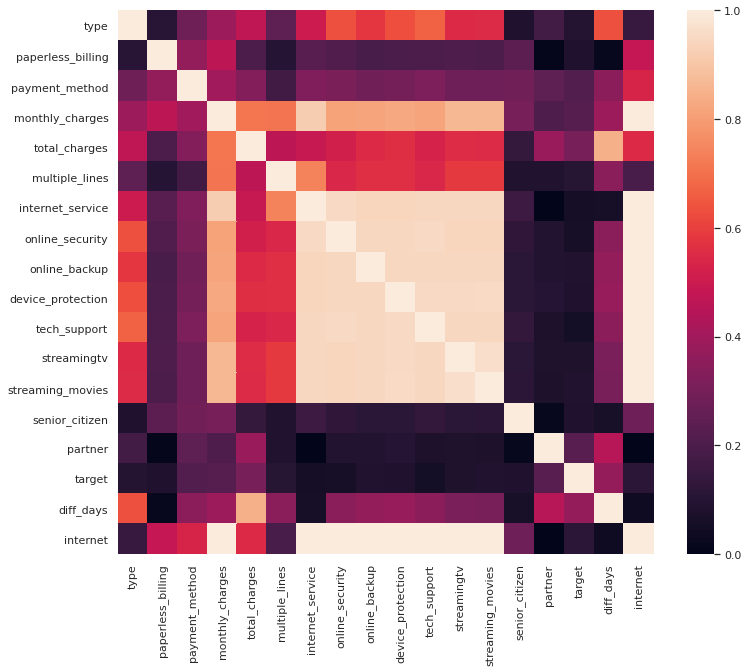

In [57]:
sns.heatmap(phik_overview);

In [58]:
phik_overview['target'].sort_values(ascending=False)

target               1.000000
diff_days            0.374101
total_charges        0.303758
partner              0.227597
monthly_charges      0.225823
payment_method       0.214300
internet             0.113949
multiple_lines       0.105172
type                 0.094622
online_backup        0.089771
streaming_movies     0.086371
senior_citizen       0.085708
device_protection    0.085665
paperless_billing    0.082789
streamingtv          0.078554
online_security      0.058630
internet_service     0.056279
tech_support         0.051442
Name: target, dtype: float64

In [59]:
df = df.drop(['internet', 'monthly_charges'], axis=1)

## Обучание моделей

### Разбиение данных на выборки

In [60]:
STATE = 40823

In [61]:
X = df.drop('target', axis=1)
y = df['target']

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                  train_size=0.75, random_state=STATE, stratify=y)

In [63]:
X_train.shape, X_test.shape

((5274, 15), (1758, 15))

In [64]:
y_train.mean(), y_test.mean()

(0.15661736822146377, 0.15642775881683732)

### Кодировка категориальных признаков

In [65]:
cat_features_for_OHE = ['type', 'paperless_billing', 'payment_method', 'multiple_lines', 'senior_citizen', 'partner', 'online_backup', 'streaming_movies', 
                'device_protection', 'streamingtv', 'online_security', 'internet_service', 'tech_support']

In [66]:
ohe = OneHotEncoder(drop='first', handle_unknown='ignore')

In [67]:
transformed = ohe.fit_transform(X_train[cat_features_for_OHE])

In [68]:
X_train.reset_index(drop=True).join(pd.DataFrame(transformed.toarray(), columns=ohe.get_feature_names_out())).isna().sum()

type                                      0
paperless_billing                         0
payment_method                            0
total_charges                             0
multiple_lines                            0
internet_service                          0
online_security                           0
online_backup                             0
device_protection                         0
tech_support                              0
streamingtv                               0
streaming_movies                          0
senior_citizen                            0
partner                                   0
diff_days                                 0
type_One year                             0
type_Two year                             0
paperless_billing_Yes                     0
payment_method_Credit card (automatic)    0
payment_method_Electronic check           0
payment_method_Mailed check               0
multiple_lines_No_service                 0
multiple_lines_Yes              

In [69]:
X_train_ohe = X_train.reset_index(drop=True).join(pd.DataFrame(transformed.toarray(), columns=ohe.get_feature_names_out()))
y_train_ohe = y_train.reset_index(drop=True)

In [70]:
X_train_ohe = X_train_ohe.drop(cat_features_for_OHE, axis=1)

In [71]:
cat_features = ['type_One year', 'type_Two year', 'paperless_billing_Yes',
               'payment_method_Credit card (automatic)',
               'payment_method_Electronic check', 'payment_method_Mailed check',
               'multiple_lines_No_service', 'multiple_lines_Yes', 'senior_citizen_1',
               'partner_Yes', 'online_backup_No_service', 'online_backup_Yes',
               'streaming_movies_No_service', 'streaming_movies_Yes',
               'device_protection_No_service', 'device_protection_Yes',
               'streamingtv_No_service', 'streamingtv_Yes',
               'online_security_No_service', 'online_security_Yes',
               'internet_service_Fiber optic', 'internet_service_No_service',
               'tech_support_No_service', 'tech_support_Yes']

In [72]:
X_train_ohe[cat_features] = X_train_ohe[cat_features].astype('int8')

In [73]:
transformed = ohe.transform(X_test[cat_features_for_OHE])

In [74]:
X_test_ohe = X_test.reset_index(drop=True).join(pd.DataFrame(transformed.toarray(), columns=ohe.get_feature_names_out()))
y_test_ohe = y_test.reset_index(drop=True)

In [75]:
X_test_ohe = X_test_ohe.drop(cat_features_for_OHE, axis=1)

In [76]:
X_test_ohe[cat_features] = X_test_ohe[cat_features].astype('int8')

### Масштабирование признаков

In [77]:
numeric = ['total_charges', 'diff_days']

scaler = StandardScaler()
scaler.fit(X_train_ohe[numeric])
X_train_ohe[numeric] = scaler.transform(X_train_ohe[numeric])

In [78]:
X_test_ohe[numeric] = scaler.transform(X_test_ohe[numeric])

## Обучение моделей

In [79]:
results = {}

### Catboost

In [80]:
cat_params = {'depth': [3, 4, 5],
            'l2_leaf_reg': [5, 7, 9], 
              'n_estimators': [300, 500, 800]}

In [81]:
cat = CatBoostClassifier(cat_features=cat_features,verbose=200, learning_rate=0.05, random_state=STATE)

In [82]:
gscv_cat = GridSearchCV(estimator=cat, param_grid=cat_params, cv=3, scoring='roc_auc', n_jobs=-1)

In [83]:
gscv_cat.fit(X_train_ohe, y_train_ohe)
gscv_cat.best_score_

0:	learn: 0.6575981	total: 47.3ms	remaining: 14.1s
200:	learn: 0.2915202	total: 241ms	remaining: 119ms
299:	learn: 0.2725976	total: 339ms	remaining: 0us
0:	learn: 0.6581028	total: 1.01ms	remaining: 301ms
200:	learn: 0.3034933	total: 217ms	remaining: 107ms
299:	learn: 0.2828310	total: 344ms	remaining: 0us
0:	learn: 0.6583473	total: 1.23ms	remaining: 369ms
200:	learn: 0.3038066	total: 233ms	remaining: 115ms
299:	learn: 0.2812738	total: 363ms	remaining: 0us
0:	learn: 0.6575981	total: 1.76ms	remaining: 878ms
200:	learn: 0.2915202	total: 211ms	remaining: 313ms
400:	learn: 0.2518162	total: 429ms	remaining: 106ms
499:	learn: 0.2337664	total: 540ms	remaining: 0us
0:	learn: 0.6581028	total: 945us	remaining: 472ms
200:	learn: 0.3034933	total: 206ms	remaining: 307ms
400:	learn: 0.2625667	total: 441ms	remaining: 109ms
499:	learn: 0.2468290	total: 547ms	remaining: 0us
0:	learn: 0.6583473	total: 1.09ms	remaining: 543ms
200:	learn: 0.3038066	total: 207ms	remaining: 308ms
400:	learn: 0.2646539	total: 

0.9040916395374935

In [84]:
gscv_cat.best_params_

{'depth': 5, 'l2_leaf_reg': 5, 'n_estimators': 800}

{'depth': 5, 'l2_leaf_reg': 5, 'n_estimators': 800}

In [85]:
results['Catboost'] = gscv_cat.best_score_

### Метод k-ближайших соседей

Подберем гиперпараметры на кросс-валидации обучающей выборки

In [86]:
knn_params = {'n_neighbors' : range(1, 11, 1)}

In [87]:
knn = KNeighborsClassifier()

In [88]:
gscv_knn = GridSearchCV(estimator=knn, param_grid=knn_params, cv=3, scoring='roc_auc', n_jobs=-1, refit=True)

In [89]:
gscv_knn.fit(X_train_ohe, y_train_ohe)
gscv_knn.best_estimator_

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:824: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 459, in _score
    y_pred = method_caller(clf, "decision_function", X, pos_label=pos_label)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 86, in _cached_call
    result, _ = _get_response_values(
  File "/opt/conda/lib/python3.9/site-packages/sklearn/utils/_response.py", line 73, in _get_response_values
    prediction_method = _check_response_method(estimator, response_method)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py", line 1940, in _check_response_method
    raise AttributeError(
AttributeError: KNeighborsClassifier has none of the following attributes: decision_function.

During handling of the above ex

KNeighborsClassifier(n_neighbors=1)

In [90]:
gscv_knn.best_score_

nan

In [91]:
results['KNN'] = gscv_knn.best_score_

### Логистическая регрессия

Подберем гиперпараметры на кросс-валидации обучающей выборки

In [92]:
lr_params = {'C' : range(1, 16, 1)}

In [93]:
lr = LogisticRegression(random_state=STATE, max_iter=1000)

In [94]:
gscv_lr = GridSearchCV(estimator=lr, param_grid=lr_params, cv=3, scoring='roc_auc', n_jobs=-1, refit=True)

In [95]:
gscv_lr.fit(X_train_ohe, y_train_ohe)
gscv_lr.best_estimator_

LogisticRegression(C=1, max_iter=1000, random_state=40823)

In [96]:
gscv_lr.best_score_

0.7691929794859567

In [97]:
results['LR'] = gscv_lr.best_score_

### Промежуточный вывод

Наилучшее качество по метрике ROC-AUC продемострировала модель CatBoost. Имеено ее будем использовать на тестовой выборке

In [98]:
pd.DataFrame.from_dict(results, orient='index', columns=['ROC-AUC']).sort_values(by='ROC-AUC', ascending=False)

,ROC-AUC
Catboost,0.904092
LR,0.769193
KNN,NaN


### Тестирование

In [99]:
params = {'verbose':100,
          'random_seed':STATE,
          'eval_metric' : 'AUC',
          'learning_rate': 0.05, 
          'random_seed': STATE, 
          'cat_features': cat_features,
          'depth': 5,
          'n_estimators': 800,
          'l2_leaf_reg': 5}

In [100]:
cat = CatBoostClassifier(**params)

In [101]:
cat.fit(X_train_ohe, y_train_ohe,eval_set=(X_test_ohe,y_test_ohe));

0:	test: 0.7301465	best: 0.7301465 (0)	total: 6.14ms	remaining: 4.91s
100:	test: 0.8360436	best: 0.8360436 (100)	total: 225ms	remaining: 1.56s
200:	test: 0.8499050	best: 0.8499050 (200)	total: 468ms	remaining: 1.4s
300:	test: 0.8803237	best: 0.8803237 (300)	total: 693ms	remaining: 1.15s
400:	test: 0.8958843	best: 0.8958843 (400)	total: 919ms	remaining: 914ms
500:	test: 0.9060970	best: 0.9062343 (499)	total: 1.15s	remaining: 686ms
600:	test: 0.9093459	best: 0.9093459 (600)	total: 1.41s	remaining: 467ms
700:	test: 0.9112708	best: 0.9112904 (696)	total: 1.64s	remaining: 231ms
799:	test: 0.9133403	best: 0.9133942 (795)	total: 1.89s	remaining: 0us

bestTest = 0.9133942255
bestIteration = 795

Shrink model to first 796 iterations.


In [116]:
cat.get_feature_importance(prettified=True)

,Feature Id,Importances
0,diff_days,55.705518
1,total_charges,10.999246
2,type_Two year,4.924000
3,partner_Yes,3.337110
4,multiple_lines_Yes,3.302298
5,type_One year,2.693055
6,payment_method_Mailed check,2.342805
7,online_backup_Yes,2.191292
8,internet_service_Fiber optic,2.183923
9,streaming_movies_Yes,1.724814


In [103]:
roc_auc_score(y_test_ohe, cat.predict_proba(X_test_ohe)[:, 1])

0.9133942254643537

Удалим из данных наимеенее важные, по мнению модели, признаки, и запустим обучение еще раз.

In [104]:
cat_features = ['type_One year', 'type_Two year', 
               'payment_method_Credit card (automatic)',
               'payment_method_Electronic check', 'payment_method_Mailed check',
               'multiple_lines_Yes', 'senior_citizen_1',
               'partner_Yes', 'online_backup_Yes', 'streaming_movies_Yes', 'device_protection_Yes',
               'streamingtv_Yes', 'online_security_Yes', 'internet_service_Fiber optic',
               'tech_support_Yes']

In [105]:
X_train_ohe = X_train_ohe.drop(['streaming_movies_No_service', 'tech_support_No_service', 'online_backup_No_service', 'device_protection_No_service', 
                                'internet_service_No_service', 'online_security_No_service', 'streamingtv_No_service', 'multiple_lines_No_service'], axis=1)

In [106]:
X_test_ohe = X_test_ohe.drop(['streaming_movies_No_service', 'tech_support_No_service', 'online_backup_No_service', 'device_protection_No_service', 
                                'internet_service_No_service', 'online_security_No_service', 'streamingtv_No_service', 'multiple_lines_No_service'], axis=1)

In [107]:
params = {'verbose':100,
          'random_seed':STATE,
          'eval_metric' : 'AUC',
          'learning_rate': 0.05, 
          'random_seed': STATE, 
          'cat_features': cat_features,
          'depth': 5,
          'n_estimators': 800,
          'l2_leaf_reg': 5}

In [108]:
cat = CatBoostClassifier(**params)

In [109]:
cat.fit(X_train_ohe, y_train_ohe,eval_set=(X_test_ohe,y_test_ohe));

0:	test: 0.6053896	best: 0.6053896 (0)	total: 1.51ms	remaining: 1.21s
100:	test: 0.8370576	best: 0.8371360 (99)	total: 270ms	remaining: 1.87s
200:	test: 0.8553154	best: 0.8553154 (200)	total: 516ms	remaining: 1.54s
300:	test: 0.8841084	best: 0.8841084 (300)	total: 713ms	remaining: 1.18s
400:	test: 0.9006645	best: 0.9006645 (400)	total: 911ms	remaining: 907ms
500:	test: 0.9074542	best: 0.9074542 (500)	total: 1.11s	remaining: 664ms
600:	test: 0.9114829	best: 0.9116006 (591)	total: 1.31s	remaining: 435ms
700:	test: 0.9142169	best: 0.9142733 (683)	total: 1.52s	remaining: 215ms
799:	test: 0.9168994	best: 0.9169313 (797)	total: 1.74s	remaining: 0us

bestTest = 0.9169312818
bestIteration = 797

Shrink model to first 798 iterations.


После удаления части признаков, качество модели немного возрасло. 

In [151]:
cat.get_feature_importance(prettified=True)

,Feature Id,Importances
0,diff_days,55.705518
1,total_charges,10.999246
2,type_Two year,4.924000
3,partner_Yes,3.337110
4,multiple_lines_Yes,3.302298
5,type_One year,2.693055
6,payment_method_Mailed check,2.342805
7,online_backup_Yes,2.191292
8,internet_service_Fiber optic,2.183923
9,streaming_movies_Yes,1.724814


In [110]:
fpr, tpr, thresholds = roc_curve(y_test_ohe, cat.predict_proba(X_test_ohe)[:, 1])

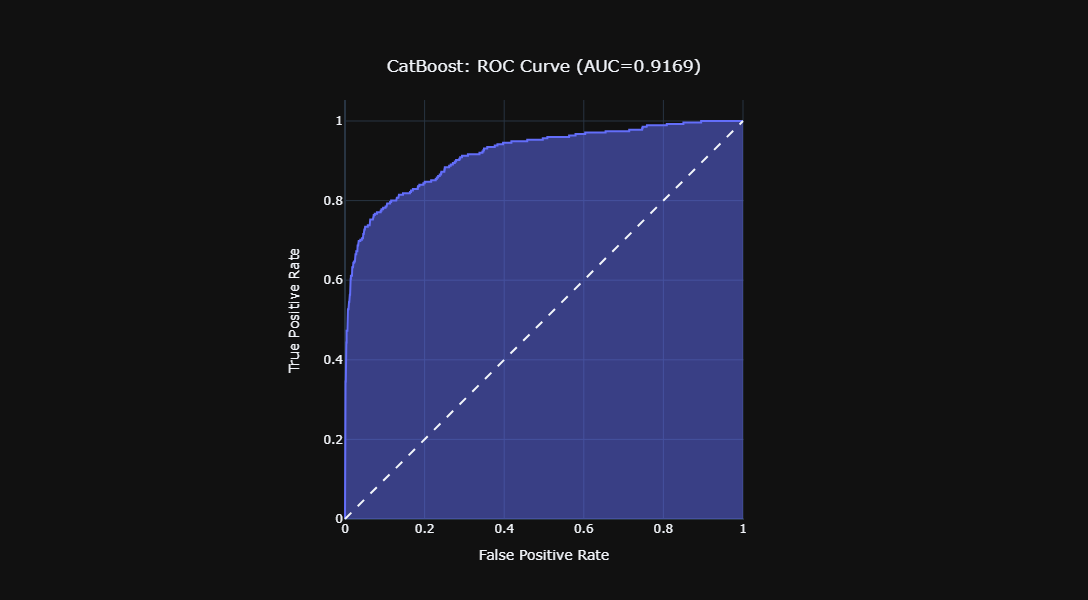

In [111]:
fig = px.area(
    x=fpr, y=tpr,
    title=f'CatBoost: ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=600, height=600
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)
fig.update_layout(template='plotly_dark',
                  title={'y':0.9,
                        'x':0.5}
)
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

In [112]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


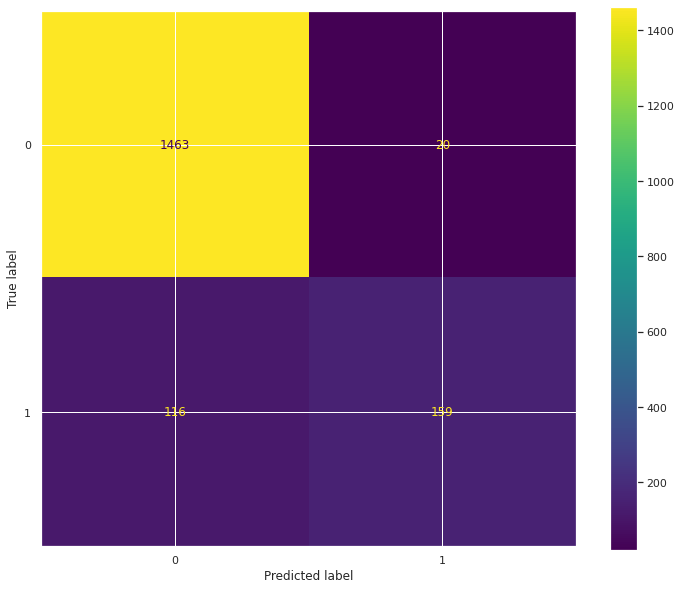

In [113]:
predictions = cat.predict(X_test_ohe)
cm = confusion_matrix(y_test_ohe, predictions, labels=cat.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=cat.classes_)
disp.plot()
plt.show()

При значении порого по умолчанию - 0.5 - модель часто дает ошибочно негативные предсказания. При этом ошибочно позитивных предсказаний достаточно мало. 

## Отчет 

Все задачи, обозначенные в изначальном плане, в целом выполнены: 
* проведен разведочный анализ данных;
* проведен поверхностный когортный анализ лояльных и нелояльных пользователей;
* подготовлены признаков для последующего обучения моделей;
* определена лучшая модель по метрике ROC-AUC;
* достигнута цель проекта - превышено пороговое значение метрики ROC-AUC.

Предоставленные данные были хорошо структурированы и практические не имели пропусков: в сырых данных имелись буквально несколько наблюдений, в которых не указаны общие траты пользователя. Это касалось только новых пользователей, которые не успели произвести оплата либо эта информация на нашла отражения на момент выгрузки данных. 

Стоит отметить, что в сырых данных присутствовал некорректный тип данных, в частности числовой признак total_charges. 

В процессе разведочного анализа данных сгенерированы дополнительные признаки: 
* временной интервал, в течение которого пользователь является клиентов компании. Для этого использовалась информация о дате  регистрация пользователя (BeginDate) и состояния клиента на момент выгрузки данных (EndDate). Особенность этих данных состоит в том, что все даты отражают только месяц события: 1 января, 1 февраля и т.д. В связи с этим изначально было принято ошибочное решение в качество временного интервала использовать количество месяцев, а не дней, что, как выяснилось в процессе обучения моделей, имеют существенное влияние на метрику качества. 
* булевые признаки, отражающие наличие у пользователя услуг интернета и телефонии, поскольку часть из них могла пользоваться услугами только интернета или телефонии. Впрочем эти признаки не имели какой-либо значимой корреляции с целевых признаком и не использовались в обучении моделей. 

Поскольку сырые данные были представлены четырьмя таблицами, их были необходимо объединить в датафрейм. В результате этого объединения в данных образовались пропуски. Это связано тем, как было отмечено выше, некоторые пользователи могли пользоваться услугами только интернета или телефонии. Были принято решение заполнить эти пропуски значением "No_service". 

Анализ корреляции признаков показал мультиколлинеарность месячных и общих трат с дополнительными сервисами. Это можно объяснить тем, что наличие таких сервисов существенно увеличивали расходы пользователей. При этом, как показал когортный анализ, именно пользователи с подключенными дополнительными сервисами более склонны в уходу, что в свою очередь можно интерпретировать, как неудовлетворенность клиентов ценовой политикой компании. Чтобы решить проблему мультиколлинеарности решено исключить из данных признак месячных трат, оставив признаки, указывающие на наличие дополнительных услуг. 

Также после анализа корреляции из данных был удален признак gender, который не показывал какой-либо корреляции с целевым признаком. 

На этапе подготовки данных были разделены на обучающие и тестовую выборки с учетом дисбаланса классов. Также произведена кодировка и масштабирование признаков. Для кодировки категориальных признаков использовался метод one hot encoding, для числовых - StandardScaler. 

<b>Проблемы и их решение</b> 

Основной проблемой, с которой пришлось столнуться в данном проекта, стал правильный выбор искусственных признаков, а именно выбор корректной единицы времени при формировании интервала, в течение которого пользователь является клиентом компании. Только день как временная единица в этом признаке позволяет модель продемострировать наилучшее качество. Как дальнейшем показала важность признаков, именно этот фактор, по мнение модели, играет решающую роль в прогнозировании оттока клиентов.

К второстепенных проблемам можно отнести мультиколлинеарность некоторых признаков, что в свою очередь решается удаление признаков с высокой корреляцией, а также выбор признаков. Поскольку далеко не всех присутствующие в данных признаки имеют высокую важность, для повышения качества прогнозирования, от ряда таких признаков следовало отказаться. В то же время стоит отметить, что качество модели в случае исключения маловажных признаков возрасло незначительно. 

<b>Ключевые шаги в решении задачи</b>

К ключевым этапам можно отнести подготовку признаков и генерацию искусственных. Именно корректность реализации этого этапа играет ключевую роль при обечении и оказывает существенное влияние на качество прогнозирования. Также на этапе важно исключить из данных ряд призанков, которые могут стать причиной 

<b>Обучение и тестирование моделей</b>

В данном проекте использовались модели:
* Catboost
* Метод k-ближайших соседей
* Логистическая регрессия

Подбор гиперпараметров осуществлен при помощи GridSearch на кросс-валидации. На обучении модели показали следующие результаты:



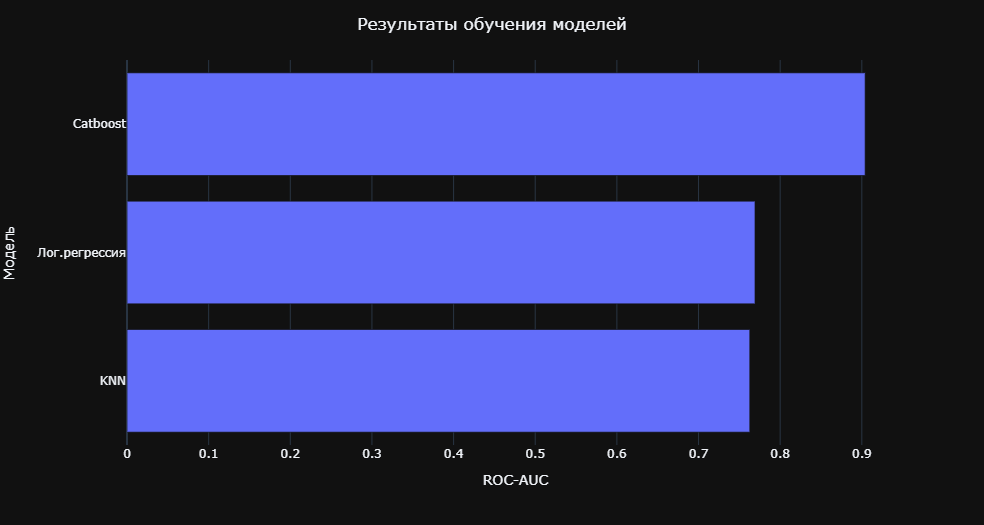

Наилучший результат продемонстрировала модель Catboost. Именно она и была выбрана в качестве основной модели для тестирования со следующими значениями гиперпараметров:
* random_seed: 40823,
* learning_rate: 0.05, 
* depth: 5,
* n_estimators: 800,
* l2_leaf_reg: 5.

При первом тестировании значение ROC-AUC составило 0.9133. После анализа важности признаков и удаления наименее важных удалось достичь значения 0.9169. 

Значение дополнительной метрики -  accuracy: 0.9226.

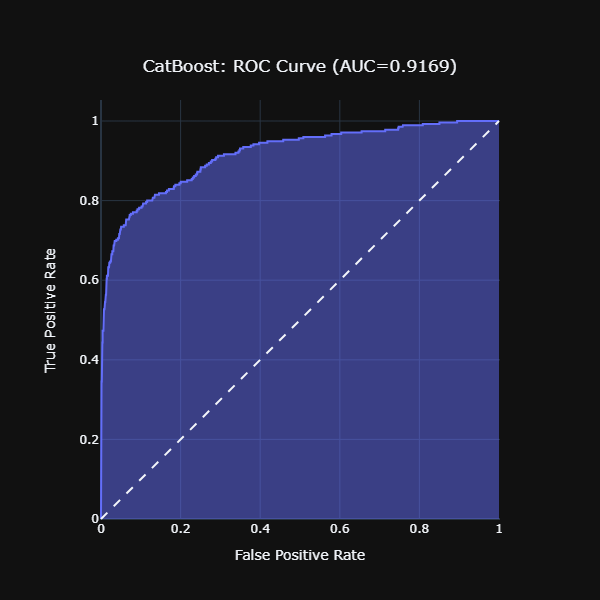

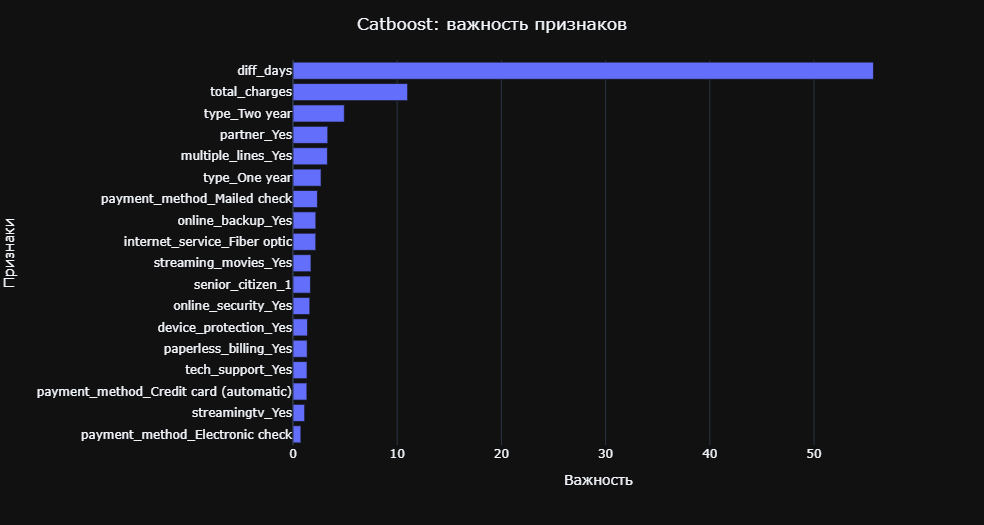

При значении порога по умолчанию - 0.5 - модель часто дает ошибочно негативные предсказания. При этом ошибочно позитивных предсказаний достаточно мало. Исходя их целей бизнеса, если необходимо обеспечить бОльший охват потенциально нелояльных клиентов, значение порога следует понизить. Это позволит снизить количество ошибочно негативных предсказаний, охватив пользователей, склонных к оттоку. Но в то же время возрастет и число ошибочно позитивных предсказаний. 

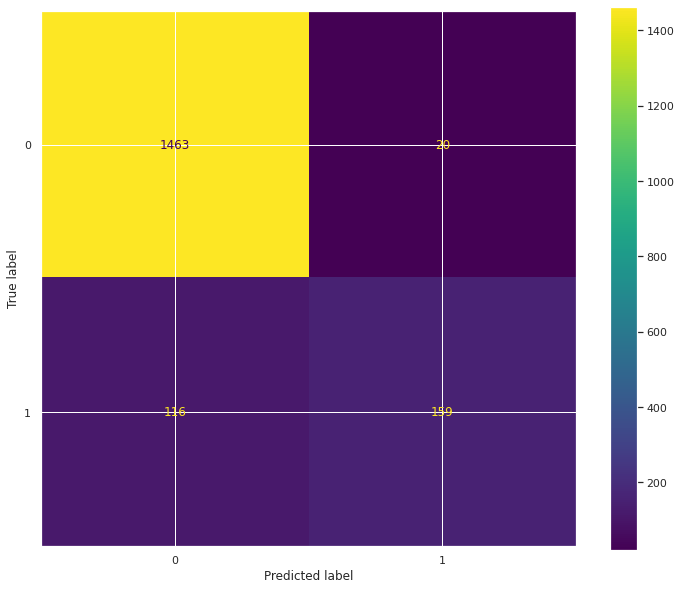